# Natural Language Processing
## Fake News Detection 

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip3 install pytest-runner --upgrade
!pip3 install ftfy
import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# import libraries

import ftfy
import nltk
import json
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import csv
import numpy as np
import nltk
import seaborn as sb
import warnings

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import Binarizer


from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
#nltk.download('stopwords')


from wordcloud import STOPWORDS, WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, naive_bayes, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier # need to import xboost calssifer

warnings.filterwarnings('ignore')
np.random.seed(0)

# Loading the LIAR Dataset
The dataset is in the format of 3 tab seperated files. Loading it as a pandas dataframe. Combining the train, test and validation files to a single file so that we can do the train and test split as required.

In [33]:
# Importing the dataset
train = pd.read_csv('/content/drive/MyDrive/mini_project/data_file/train.tsv', delimiter='\t', quoting=3, header=None)
test = pd.read_csv('/content/drive/MyDrive/mini_project/data_file/test.tsv', delimiter='\t', quoting=3, header=None)
valid = pd.read_csv('/content/drive/MyDrive/mini_project/data_file/valid.tsv', delimiter='\t', quoting=3, header=None)

In [34]:
df_raw = pd.concat([train, test, valid], axis=0, sort=False)
df_raw = df_raw.sample(frac=1).reset_index()
df_raw.head(2)

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [35]:
# The file contains 12836 rows and 15 columns
df_raw.shape

(12836, 15)

In [36]:
# naming the columns of the dataset
df_raw.columns=["index","ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]

In [37]:
df_raw.head(2)

,index,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,8289,423.json,true,"""McCain opposes a woman's right to choose.""",abortion,moveon,NaN,NaN,democrat,2,4,3,0,0,an e-mail message
1,1156,10379.json,barely-true,The name Frank has risen in popularity by 20 p...,pop-culture,matt-lauer,Today Show host,NaN,none,1,0,0,0,0,a red carpet interview before the Golden Globes


In [38]:
# some of the statements
df_raw['statement'].head(10).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.',
 'Says the United States does not trade as much as other developed nations.',
 '"Oil companies ...currently have 68-million acres that they\'re not using."',
 'Says 24 million people in this country cant find a full-time job, 50 million cant see a doctor when theyre sick, 47 million people need government help to feed themselves and 15 million families owe more than the value of their home.',
 'President Obama went around the world and apo

In [39]:
# some of the speakers
df_raw['speaker'].head(20).tolist()

['moveon',
 'matt-lauer',
 'donald-trump',
 'candy-crowley',
 'ted-cruz',
 'rob-portman',
 'barack-obama',
 'alan-grayson',
 'mitt-romney',
 'joe-biden',
 'ellen-rosenblum',
 'linda-finn',
 'us-chamber-commerce',
 'tom-barrett',
 'chris-christie',
 'russell-edwards',
 'mitt-romney',
 'jeff-merkley',
 'rush-limbaugh',
 'john-boehner']

# Exploratory Data Analysis

Text(0.5, 1.0, 'Types & Number of Classes in the dataset')

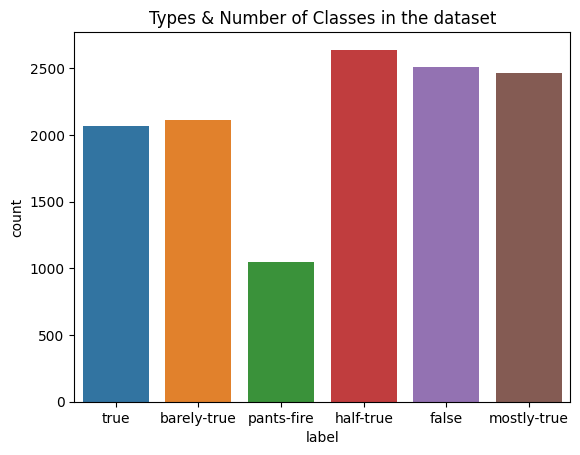

In [40]:
sns.countplot(x='label',data=df_raw)
plt.title('Types & Number of Classes in the dataset')

# Using CountVectorizer for Extracting features from 'statements' in LIAR dataset

In [41]:
# specifying features and labels
X= df_raw['statement']
y=df_raw['label']

In [42]:
# sample statements
X.head(5).tolist()

['"McCain opposes a woman\'s right to choose."',
 'The name Frank has risen in popularity by 20 percent since the debut of House of Cardson Netflix.',
 'Says Ted Cruz never denied his father was photographedwith Lee Harvey Oswald.',
 'Its been 14 years since a president or a vice president or a member of their family has not gone and attended at least an event at the Olympics.',
 'In the year 2013, the Obama administration released 104,000 criminal illegal aliens. They released 196 murderers people with homicide convictions, who are here illegally.']

In [43]:
#sample labels
y.head(5)

0           true
1    barely-true
2     pants-fire
3           true
4      half-true
Name: label, dtype: object

In [44]:
# specifying train and test split with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

10268 2568
10268 2568


### Custom Pre - Processing and Tokenisation of the data

In [45]:

""" Regular expression for cleaning the statements"""

hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")
extras_re = re.compile("[.;:!\'?,\"()\[\]]")
#apos_re = "\'[a-z]*"
#leftover_re = "\S+"

""" Preprocessing the text in the statements"""
def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = extras_re.sub("",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

# regular expression for custom tokenisation"
tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)

# defining 3 types of tokenisation

def custom_tokenise(text):
    return tokenise_re.findall(text.lower())

def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words


def nltk_twitter_tokenise(text):
    twtok = nltk.tokenize.TweetTokenizer()
    return twtok.tokenize(text.lower())

# stop words list set to english
stopwords_list = stopwords.words('english') # stop word list



### Defining custom functions for displaying results of Classification

In [46]:
# function for results of cross-validation
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))


# fucntion for results of model fitting
def print_scores():
    print("Accuracy: ", accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print(confusion_matrix(y_test, predictions))
    
# function for displaying confusion matrix
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (10, 8)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="BuPu", center=0, fmt='g')
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

# function for displaying confusion matrix in percentage terms
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="PiYG", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    
#list(df_columns.columns))-list(df_raw['labels'])"coolwarm"'Blues'PiYG'BuPu'

## Creating Pipeline with CountVectorizer with Custom preprocessing, Tokenisation, Stopwords, Normalistion (using TFIDTransformer), Feature selection and Logistic regression classifier

In [59]:
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm2', TfidfTransformer(norm=None)),
    ('selector', SelectKBest(chi2, k=1000)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [48]:
# fitting the model
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores() # using the predefined function to display results of the classification

Accuracy:  0.24182242990654207
              precision    recall  f1-score   support

 barely-true       0.25      0.17      0.20       422
       false       0.22      0.40      0.28       502
   half-true       0.24      0.25      0.25       528
 mostly-true       0.26      0.25      0.25       493
  pants-fire       0.32      0.15      0.20       210
        true       0.26      0.15      0.19       413

    accuracy                           0.24      2568
   macro avg       0.26      0.23      0.23      2568
weighted avg       0.25      0.24      0.23      2568

[[ 71 162  85  64  17  23]
 [ 59 202 109  76  18  38]
 [ 60 172 134  94  15  53]
 [ 32 158 120 121   9  53]
 [ 28  84  39  19  31   9]
 [ 29 146  75  93   8  62]]


In [49]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()
# the accuracy is reduced so reverting back without setting max features

Accuracy:  0.24182242990654207
              precision    recall  f1-score   support

 barely-true       0.25      0.17      0.20       422
       false       0.22      0.40      0.28       502
   half-true       0.24      0.25      0.25       528
 mostly-true       0.26      0.25      0.25       493
  pants-fire       0.32      0.15      0.20       210
        true       0.26      0.15      0.19       413

    accuracy                           0.24      2568
   macro avg       0.26      0.23      0.23      2568
weighted avg       0.25      0.24      0.23      2568

[[ 71 162  85  64  17  23]
 [ 59 202 109  76  18  38]
 [ 60 172 134  94  15  53]
 [ 32 158 120 121   9  53]
 [ 28  84  39  19  31   9]
 [ 29 146  75  93   8  62]]


#### Using Binarizer for normalisation instead of TfidfTransformer (i.e. scale to 0 for not present or 1 for present at any frequency), this is useful when documents are shorts as 'statements' in LIAR dataset

In [50]:

model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='word',preprocessor=preprocess,tokenizer=Tokenizer,stop_words=stopwords_list)),
    ('norm', Binarizer()),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [51]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()


Accuracy:  0.2472741433021807
              precision    recall  f1-score   support

 barely-true       0.25      0.23      0.24       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.30      0.28       528
 mostly-true       0.25      0.25      0.25       493
  pants-fire       0.24      0.14      0.17       210
        true       0.23      0.21      0.22       413

    accuracy                           0.25      2568
   macro avg       0.24      0.23      0.24      2568
weighted avg       0.25      0.25      0.25      2568

[[ 98 100  94  60  23  47]
 [ 82 140  96  89  28  67]
 [ 67 100 157 103  19  82]
 [ 71  98 108 123   8  85]
 [ 41  57  46  21  29  16]
 [ 35  88  83 104  15  88]]


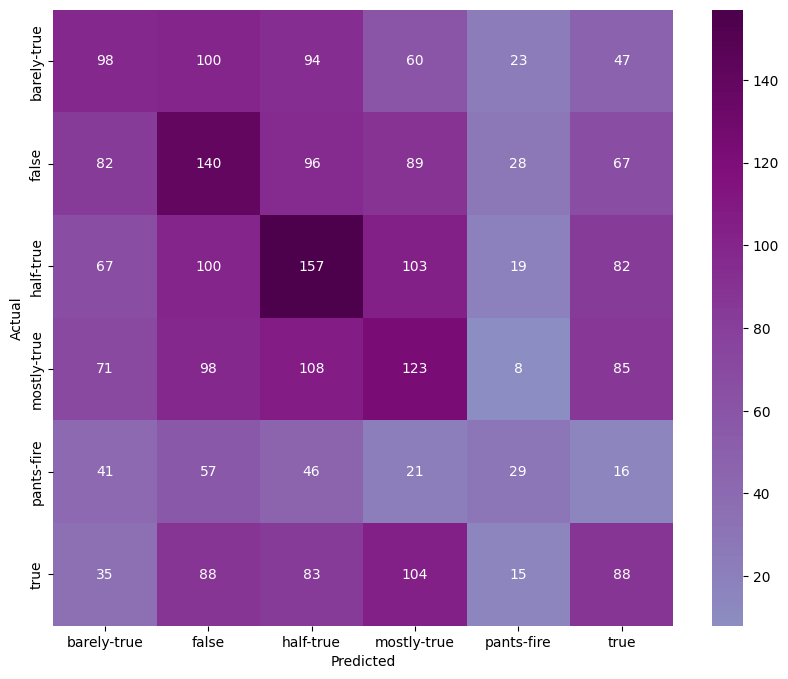

In [52]:
confusion_matrix_heatmap(confusion_matrix(y_test,predictions), model.classes_)

In [53]:
# code to view the selected features
vectorizer = CountVectorizer(analyzer='word')
selector = SelectKBest(chi2, k=100)
feats = vectorizer.fit_transform(X_train)
filtered = selector.fit_transform(feats, y_train)

In [54]:
# from itertools import compress
# cols = selector.get_support()
# names = vectorizer.get_feature_names()

# print(list(compress(names,cols)))

In [55]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.2472741433021807
              precision    recall  f1-score   support

 barely-true       0.25      0.23      0.24       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.30      0.28       528
 mostly-true       0.25      0.25      0.25       493
  pants-fire       0.24      0.14      0.17       210
        true       0.23      0.21      0.22       413

    accuracy                           0.25      2568
   macro avg       0.24      0.23      0.24      2568
weighted avg       0.25      0.25      0.25      2568

[[ 98 100  94  60  23  47]
 [ 82 140  96  89  28  67]
 [ 67 100 157 103  19  82]
 [ 71  98 108 123   8  85]
 [ 41  57  46  21  29  16]
 [ 35  88  83 104  15  88]]


In [56]:
# Fitting C-Support Vector Classifier
model.set_params(clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23325545171339565
              precision    recall  f1-score   support

 barely-true       0.20      0.25      0.22       422
       false       0.24      0.28      0.26       502
   half-true       0.27      0.27      0.27       528
 mostly-true       0.25      0.22      0.23       493
  pants-fire       0.21      0.16      0.18       210
        true       0.22      0.17      0.19       413

    accuracy                           0.23      2568
   macro avg       0.23      0.22      0.23      2568
weighted avg       0.23      0.23      0.23      2568

[[104 108  88  51  26  45]
 [117 141  74  74  39  57]
 [105  94 141  93  31  64]
 [ 94  98 107 109  11  74]
 [ 53  58  33  18  33  15]
 [ 59  98  80  90  15  71]]


In [57]:
# fitting Decision tree classifier
decision_tree=tree.DecisionTreeClassifier(random_state=1000)
model.set_params(clf=decision_tree)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.23208722741433022
              precision    recall  f1-score   support

 barely-true       0.20      0.18      0.19       422
       false       0.27      0.32      0.30       502
   half-true       0.24      0.24      0.24       528
 mostly-true       0.24      0.25      0.25       493
  pants-fire       0.15      0.13      0.14       210
        true       0.21      0.20      0.20       413

    accuracy                           0.23      2568
   macro avg       0.22      0.22      0.22      2568
weighted avg       0.23      0.23      0.23      2568

[[ 76 103  91  72  28  52]
 [ 80 162  88  77  36  59]
 [ 67 111 126 108  36  80]
 [ 60  99  89 124  27  94]
 [ 36  49  37  39  27  22]
 [ 55  71  90  91  25  81]]


In [58]:
# fitting Random forest classifier
model.set_params(clf=RandomForestClassifier(random_state=1000))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print_scores()

Accuracy:  0.25272585669781933
              precision    recall  f1-score   support

 barely-true       0.24      0.14      0.18       422
       false       0.25      0.44      0.32       502
   half-true       0.26      0.26      0.26       528
 mostly-true       0.26      0.29      0.27       493
  pants-fire       0.42      0.10      0.17       210
        true       0.21      0.15      0.18       413

    accuracy                           0.25      2568
   macro avg       0.27      0.23      0.23      2568
weighted avg       0.26      0.25      0.24      2568

[[ 59 149  99  75   7  33]
 [ 50 223  94  73  10  52]
 [ 56 146 139 120   6  61]
 [ 35 132 100 142   6  78]
 [ 25  85  38  27  22  13]
 [ 24 146  70 107   2  64]]
